# Neural Galerkin schemes with embeddings: Overview and quick example

In this Notebook, we use Neural Galerkin schemes to solve the inviscid Burgers' equation. We demonstrate that Neural Galerkin schemes with embeddings can be used to ensure that certain quantities of the solution are conserved over time to machine precision.

The inviscid Burgers' equation is given by
\begin{equation}
\partial_t \mathbf{u} + \partial_x \mathbf{u} \cdot \mathbf{u} = 0, \quad \mathbf{u}(0, x) = \mathbf{u}_0(x).
\tag{1}
\end{equation}
It is a nonlinear partial differential equation (PDE), which we aim to solve in the 1-dimensional spatial domain $\mathcal{X} = [-1, 1)$ with periodic boundary conditions for times $\mathcal{T} = [0, 1]$.
Here, we are interested in so-called *conserved quantities*. These are quantities of the solution that do not change over time. As an example, the integral
\begin{equation}
I(\mathbf{u}(t, \cdot)) = \int_{-1}^{1}\mathbf{u}(t, x) \mathrm{d}x
\tag{2}
\end{equation}
of the solution to the inviscid Burgers' equation is such a conserved quantity. That is $I(\mathbf{u}(t, \cdot)) = I(\mathbf{u}(0, \cdot))$ for
all $t \in [0, 1]$.

In this notebook, we aim to compute a numerical solution $\mathbf{\hat u}$ that satisfies ($1$) in a variational sense and that also has the conserved quantity ($2$). We parameterize the solution $\mathbf{\hat u}$ using a deep neural networks via *Neural Galerkin schemes* [<span style="color:green">1</span>] that we have extended to include the preservation of structure and invariants.

We import `jax` and `flax` for automatic differentiation and for the definition
of our Neural Network. Moreover, we define the constants that describe our domain
and set solver parameters that are used below.

In [99]:
import jax
from jax.random import key
from typing import Callable
import optax
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt
jax.config.update("jax_enable_x64", True)

In [100]:
DOMAIN_LENGTH = 2
BUMP_WIDTH = 3
TIME_STEP = 5e-3
TIMEPOINTS = jnp.arange(0.0, 1.0, TIME_STEP)
REGULARIZATION = 1e-5
# Periodic domain -> exclude endpoint
SAMPLES = jnp.expand_dims(jnp.linspace(-1, 1, 200, endpoint=False), 1)

## Model and problem setup

We define a simple fully-connected feedforward network as ansatz/parameterization for the PDE parameterization. We apply `sin` and `cos` to the input $x \in \mathcal{X}$ to ensure that the ansatz satisfies the periodic boundary conditions.

The function `ansatz` that we define from the `flax` model takes the vectorized DNN parameters $\mathbf{\theta}$ (`theta` in our code) and $x$, the spatial coordinate, as inputs. We use `ansatz` to parameterize the solution of the PDE at each point in time as $\mathbf{\hat u}(\theta, x)$.

In [113]:
class SimpleModel(nn.Module):
    period: float
    shift_init: Callable = nn.initializers.lecun_normal()

    @nn.compact
    def __call__(self, x):
        shifts = self.param(
            "shifts",
            self.shift_init,
            (x.shape[-1], 10),
        )
        x_periodic = jnp.cos(2 * jnp.pi * x / self.period + shifts)
        x = jnp.sin(x)
        x = nn.Dense(10, dtype=jnp.float64, param_dtype=jnp.float64)(x_periodic)
        x = jnp.sin(x)
        x = nn.Dense(10, dtype=jnp.float64, param_dtype=jnp.float64)(x_periodic)
        x = jnp.sin(x)
        x = nn.Dense(10, dtype=jnp.float64, param_dtype=jnp.float64)(x)
        x = jnp.sin(x)
        x = nn.Dense(1, dtype=jnp.float64, param_dtype=jnp.float64)(x)
        return jnp.squeeze(x)


model = SimpleModel(period=DOMAIN_LENGTH)

# Initialize the model for a 1D-domain
random_sample = jax.random.uniform(key(0), shape=(1,))
# key1, key2 = jax.random.split(jax.random.key(0), 2)
params = model.init(jax.random.key(0), random_sample)

# Obtain parameter vector theta from the pytree `params`
theta, ravel_fn = jax.flatten_util.ravel_pytree(params)


def ansatz(theta, x):
    return model.apply(ravel_fn(theta), x)

Next we define the Burgers' equation and its conserved quantity in terms of an ansatz function. We use `jax` differentiation concepts to represent the PDE and we use a sampling-based approach to approximate the integral.

In [114]:
def get_burgers_rhs(ansatz):
    def burgers_rhs(theta, x):
        return -jax.grad(ansatz, 1)(theta, x) * ansatz(theta, x)

    return burgers_rhs


def get_estimate_integral(ansatz):
    ansatz_batched = jax.vmap(ansatz, in_axes=[None, 0])

    def integral(theta):
        return 2 * jnp.sum(ansatz_batched(theta, SAMPLES)) / len(SAMPLES)

    return integral

We can now fit our ansatz to some given initial condition $\mathbf{u}_0$. For this we use a
standard `optax`-based ADAM solver.

step 0, loss: 1.245962598853071
step 2500, loss: 8.457693560197028e-08
step 5000, loss: 3.928366651976307e-08
step 7500, loss: 3.013622250359806e-08
step 10000, loss: 2.379857663539172e-08


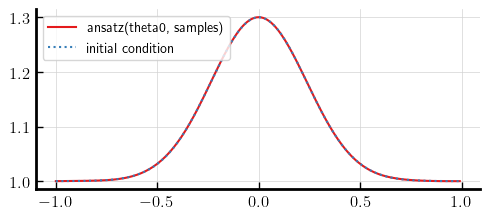

In [116]:
def u0(x):
    return jnp.squeeze(0.3 * jnp.exp(-(BUMP_WIDTH**2) * x**2) + 1)


ansatz_batched = jax.vmap(ansatz, in_axes=[None, 0])


# Fit initial Condition
def loss(theta):
    return jnp.mean(jnp.square((ansatz_batched(theta, SAMPLES) - u0(SAMPLES))))


def fit(params, optimizer):
    opt_state = optimizer.init(params)

    @jax.jit
    def step(params, opt_state):
        loss_value, grads = jax.value_and_grad(loss)(params)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss_value

    for i in range(10001):
        params, opt_state, loss_value = step(params, opt_state)
        if i % 2500 == 0:
            print(f"step {i}, loss: {loss_value}")

    return params


# Dramatic speed-ups can be achieved by using adaptive learning rates etc.
optimizer = optax.adam(learning_rate=1e-3)
theta0 = fit(theta, optimizer)

fig = plt.figure(figsize=(5.0, 2.3))
# Verify initial condition fit
plt.plot(
    jnp.squeeze(SAMPLES),
    ansatz_batched(theta0, SAMPLES),
    label="ansatz(theta0, samples)",
)
plt.plot(jnp.squeeze(SAMPLES), u0(SAMPLES), ":", label="initial condition")
plt.legend()

## Neural Galerkin scheme without structure or conservation

Now that we have the initial condition, we need to determine an update rule that modifies the DNN parameters `theta` such that the ansatz approximates the PDE solution at a later time. In [<span style="color:green">1</span>], the authors show that a time-dependent parameter function $\mathbf{\theta}: \mathcal{T} \to \mathbb{R}^{n_\mathbf{\theta}}$ can be found as the solution to an ordinary differential equation (ODE) (or as a differential-algebraic equation (DAE)) using the *Dirac-Frenkel variational principle*. In this way, we can determine an approximate solution $\hat u(\mathbf{\theta}(t), x)$ for the original PDE problem. Here, $\hat u$ is
the `ansatz`-function, we have defined above. We get a formulation for the time derivative of $\theta$, $\mathbf{\dot \theta}$, as the solution of the least-squares problem

\begin{equation}
\min_\eta
\left\|
\underbrace{
\begin{bmatrix}
    \nabla_{\mathbf{\theta}}(\mathbf{\hat u}({\mathbf{\theta}}(t), x_1)) \\
    \vdots \\
    \nabla_{\mathbf{\theta}}(\mathbf{\hat u}(\mathbf{\theta}(t), x_n)) \\
\end{bmatrix}
}_{A(t)}
\eta
-
\underbrace{
\begin{bmatrix}
    \mathbf{f}(\mathbf{\hat u}(\mathbf{\theta}(t), \cdot), x_1) \\
    \vdots \\
    \mathbf{f}(\mathbf{\hat u}(\mathbf{\theta}(t), \cdot), x_n) \\
\end{bmatrix}
}_{b(t)}
\right\|_2^2.
\tag{3}
\end{equation}
Here $\mathbf{f}$ is just the function generated by `get_burgers_rhs`. The points $\{x_1, \dots, x_n\} \subset \mathcal{X}$ are the `SAMPLES`, we have defined above.

We can use a regularized solver of the least-squares problem to transform $(3)$ into a right-hand-side function that we can plug into a standard ODE solver. Here, we use an off-the-shelf 4th-order Runge-Kutta solver to obtain a solution in time for $\mathbf{\theta}$ and thus an approximate solution for the PDE problem.

In [117]:
def get_plain_neural_galerkin_rhs(ansatz, rhs):
    A = jax.vmap(jax.grad(ansatz), in_axes=[None, 0])
    b = jax.vmap(rhs, in_axes=[None, 0])

    def ng_rhs(theta):
        A_eval = jnp.squeeze(A(theta, SAMPLES))
        b_eval = jnp.squeeze(b(theta, SAMPLES))
        thetadot = jnp.squeeze(
            jnp.linalg.lstsq(A_eval, b_eval, REGULARIZATION)[0]
        )
        return thetadot

    return ng_rhs


def get_rk4_step(rhs):
    h = TIME_STEP

    def rk4_step_fn(theta, t):
        k1 = rhs(theta)
        k2 = rhs(theta + h * k1 / 2)
        k3 = rhs(theta + h * k2 / 2)
        k4 = rhs(theta + h * k3)
        theta_new = theta + 1.0 / 6.0 * h * (k1 + 2 * k2 + 2 * k3 + k4)
        return theta_new, theta_new

    return rk4_step_fn


def odeint_rk4(fn, theta0, timepoints):
    _, y = jax.lax.scan(get_rk4_step(fn), theta0, timepoints)
    return y


rhs = get_burgers_rhs(ansatz)
normal_ng_rhs = get_plain_neural_galerkin_rhs(ansatz, rhs)
conserved_qty = get_estimate_integral(ansatz)
conserved_qty_batched = jax.vmap(conserved_qty)
thetas_time = odeint_rk4(normal_ng_rhs, theta0, TIMEPOINTS)

### Evaluation and problem description

If we evaluate the solution, we can see that we get an accurate solution for Burgers'
PDE $(1)$. However, the conserved quantity $(2)$ of true solutions to Burgers' PDE is not conserved with the Neural Galerkin approximation.

Text(0, 0.5, 'Conservation Error')

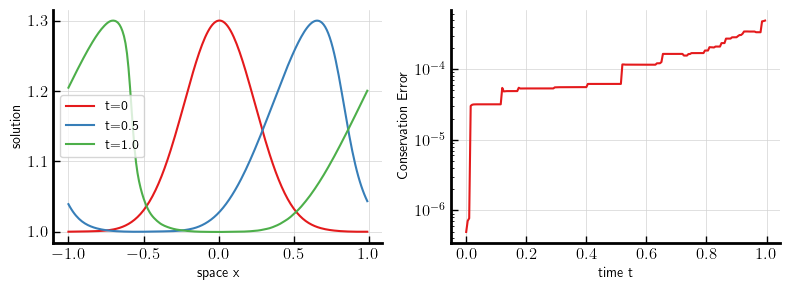

In [118]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(8, 3))
ax0.plot(SAMPLES, ansatz_batched(thetas_time[0], SAMPLES), label="t=0")
ax0.plot(SAMPLES, ansatz_batched(thetas_time[100], SAMPLES), label="t=0.5")
ax0.plot(SAMPLES, ansatz_batched(thetas_time[199], SAMPLES), label="t=1.0")
ax0.legend()
ax0.set_xlabel("space x")
ax0.set_ylabel("solution")
conservation_error_plain = conserved_qty(theta0) - conserved_qty_batched(thetas_time)
ax1.semilogy(TIMEPOINTS, jnp.abs(conservation_error_plain))
ax1.set_xlabel("time t")
ax1.set_ylabel("Conservation Error")

## Neural Galerkin with constraints

This is because the conserved quantity (the integral of the solution) of
Burgers' PDE is not necessarily a conserved quantity of the Neural Galerkin equation $(3)$. Let's try to fix this by just adding a constraint
\begin{equation}
\frac{\mathrm{d}I(\mathbf{\hat u}(t, \cdot))}{\mathrm{d}t} = 0
\tag{4}
\end{equation}
to $(3)$. We can implement this by solving a constrained least-squares problem, that incorporates $(4)$. The function below simply solves the least-squares problem in a subspace, in which $(4)$ is satisfied (More precisely, we just ensure that the time derivative with respect to the sampled approximation, defined in the function `integral` is zero).

Text(0, 0.5, 'Conservation Error')

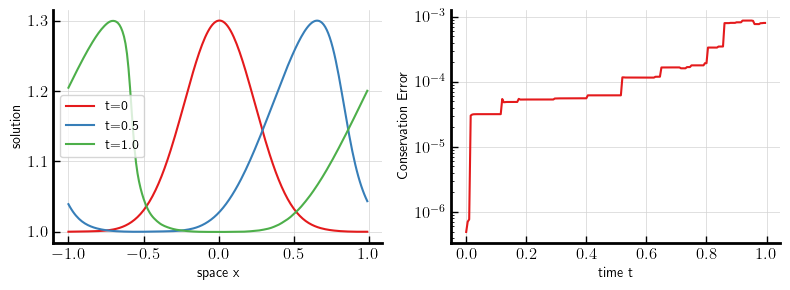

In [119]:
def get_constrained_ng_rhs(ansatz, rhs, conserved_qty_fn):
    A = jax.vmap(jax.grad(ansatz), in_axes=[None, 0])
    b = jax.vmap(rhs, in_axes=[None, 0])
    g = jax.grad(conserved_qty_fn)

    def ng_rhs(theta):
        A_eval = A(theta, SAMPLES)
        b_eval = jnp.squeeze(b(theta, SAMPLES))
        g_eval = g(theta)
        g_normal = g_eval / jnp.linalg.norm(g_eval)
        AP = A_eval - jnp.outer(A_eval @ g_normal, g_normal)
        thetadot_subsp, _, _, _ = jnp.linalg.lstsq(
            AP, b_eval, rcond=REGULARIZATION
        )
        return thetadot_subsp - jnp.inner(thetadot_subsp, g_normal) * g_normal

    return ng_rhs


constrained_ng_rhs = get_constrained_ng_rhs(ansatz, rhs, conserved_qty)
thetas_constrained_time = odeint_rk4(constrained_ng_rhs, theta0, TIMEPOINTS)
tct = thetas_constrained_time

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(8, 3))
ax0.plot(SAMPLES, ansatz_batched(tct[0], SAMPLES), label="t=0")
ax0.plot(SAMPLES, ansatz_batched(tct[100], SAMPLES), label="t=0.5")
ax0.plot(SAMPLES, ansatz_batched(tct[199], SAMPLES), label="t=1.0")
ax0.legend()
ax0.set_xlabel("space x")
ax0.set_ylabel("solution")
conservation_error_constrained = conserved_qty(theta0) - conserved_qty_batched(tct)
ax1.semilogy(TIMEPOINTS, jnp.abs(conservation_error_constrained))
ax1.set_xlabel("time t")
ax1.set_ylabel("Conservation Error")

This does not preserve the invariant. We cannot ensure that `integral` is conserved even though we have forced it to be a conserved quantity of the Neural Galerkin ODE. The off-the-shelf Runnge-Kutta integrator can in general only preserve *linear* conserved quantities of a given ODE. While the integral is of course linear in $\hat u(\theta(t), \cdot)$, it is a **nonlinear** quantity in $\theta(t)$ because $\hat u$ depends nonlinearly on $\theta(t)$ and the ODE is formulated in terms of $\theta$.

## Neural Galerkin with embeddings for preserving structure and invariants

To address the previous problem, we use a *projection-method* to ensure that `integral` is also conserved after time-discretization. This is called Neural Galerkin with embeddings because in using this projection-method, we ensure that our solution stays on the manifold
\begin{equation}
\mathcal{M}_I := \{\hat u(\mathbf{\eta}, \cdot) : \mathbf{\eta} \in \mathbb{R}^{n_\theta} \text{ and } I(\eta) = I(\mathbf{\theta}_0)\},
\tag{5}
\end{equation}
which is embedded in the Manifold $\mathcal{M}_\Theta$, in which Neural Galerkin approximates the solution to the PDE. More on this can be found in Section 3.1 of our preprint. In our implementation, we solve a nonlinear least-squares problem for which we use a simplified Newton iteration as explained in [<span style="color:green">2</span>] and Section 5.2 of our preprint.

In [120]:
def get_manifold_projection(manifold_fn):
    g = jax.jacrev(manifold_fn)

    def cond_fn(val):
        i, _, delta_corrector, _ = val
        return jax.numpy.logical_and(
            i < 10, jnp.linalg.norm(delta_corrector) > 1e-16
        )

    def body_fn(val):
        i, corrector, delta_corrector, x = val
        gx = g(x)
        mfn = manifold_fn(x + gx * corrector)
        delta_corrector = -mfn / (jnp.inner(gx, gx))
        corrector = corrector + delta_corrector
        valp1 = (i + 1, corrector, delta_corrector, x)
        return valp1

    def manifold_projection(y):
        val = (0, 0.0, 1.0, y)
        final_val = jax.lax.while_loop(cond_fn, body_fn, val)
        _, corrector, _, _ = final_val
        y_on_manifold = y + g(y) * corrector
        return y_on_manifold

    return manifold_projection


def odeint_projected_rk4(fn, theta0, timepoints, manifold_fn):
    manifold_projection = get_manifold_projection(manifold_fn)
    rk4_step = get_rk4_step(fn)

    def projected_rk4_step(theta, t):
        theta_tilde, _ = rk4_step(theta, 0)
        theta_new = manifold_projection(theta_tilde)
        return theta_new, theta_new

    _, y = jax.lax.scan(
        projected_rk4_step,
        theta0,
        timepoints,
    )
    return y

Text(0, 0.5, 'Conservation Error')

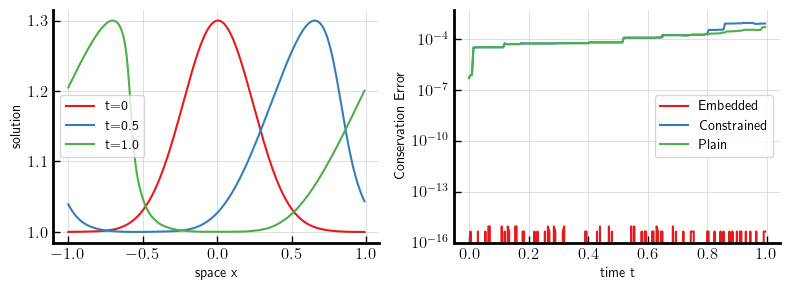

In [121]:
manifold_fn = lambda x: conserved_qty(theta0) - conserved_qty(x)
thetas_embedded_time = odeint_projected_rk4(
    constrained_ng_rhs, theta0, TIMEPOINTS, manifold_fn
)

tet = thetas_embedded_time

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(8, 3))
ax0.plot(SAMPLES, ansatz_batched(tet[0], SAMPLES), label="t=0")
ax0.plot(SAMPLES, ansatz_batched(tet[100], SAMPLES), label="t=0.5")
ax0.plot(SAMPLES, ansatz_batched(tet[199], SAMPLES), label="t=1.0")
ax0.legend()
ax0.set_xlabel("space x")
ax0.set_ylabel("solution")
conservation_error_embedded = conserved_qty(theta0) - conserved_qty_batched(tet)
ax1.semilogy(TIMEPOINTS, jnp.abs(conservation_error_embedded), label="Embedded")
ax1.semilogy(TIMEPOINTS, jnp.abs(conservation_error_constrained), label="Constrained")
ax1.semilogy(TIMEPOINTS, jnp.abs(conservation_error_plain), label="Plain")
ax1.set_ylim((1e-16, 5e-3))
ax1.legend()
ax1.set_xlabel("time t")
ax1.set_ylabel("Conservation Error")

Using Neural Galerkin schemes with embeddings, the conserved quantity of the original PDE is also a conserved quantity of solution. Moreover, the Newton iteration converges in just a few steps such that we get little computational extra costs.

## References

[<span style="color:green">1</span>] J. Bruna, B. Peherstorfer, and E. Vanden-Eijnden, *Neural Galerkin scheme with active
learning for high-dimensional evolution equations*, Preprint, (2022), https://doi.org/10.48550/arXiv.2203.01360. 

[<span style="color:green">2</span>] E. Hairer, G. Wanner, and C. Lubich, *Geometric Numerical Integration, Structure-Preserving Algorithms for Ordinary Differential Equations*, Springer Berlin, Heidelberg, 2006 https://doi.org/10.1007/3-540-30666-8.